In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

device = torch.device('cpu')


In [2]:
# Define the exact solution
def exact_solution_u(x, t):
    return (2.5*pi*torch.cos(x)+(x-pi*2.5))*torch.cos(t)

def initial_condition_u(x):
    return 2.5*pi*torch.cos(x) + (x - pi*2.5)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x)

# Define the exact solution
def exact_solution_p(x, t):
    return 2.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return 2.5*pi*torch.sin(x)

def initial_condition_p_t(x):
    return 0.0*pi*torch.cos(x)

# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

eps = 5
manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = 7*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1).to(device)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1).to(device)
w_init = torch.cat([u_init, p_init],1).to(device)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1).to(device)
p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1).to(device)
w_t_init = torch.cat([u_t_init, p_t_init],1).to(device)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = exact_solution_u(xb_left, tb_left).to(device)
p_b_l = exact_solution_p(xb_left, tb_left).to(device)
w_b_l = torch.cat([u_b_l, p_b_l],1).to(device)



xb_right = 7*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = exact_solution_u(xb_right, tb_right).to(device)
p_b_r = exact_solution_p(xb_right, tb_right).to(device)
w_b_r = torch.cat([u_b_r, p_b_r],1).to(device)

# x_interior = pi*torch.rand((residual_pts, 1))
# t_interior = torch.rand((residual_pts, 1))
# interior = torch.cat([x_interior, t_interior],1)

x_int = torch.linspace(0, 7*pi, 102)
x_int = x_int[1:-1]

t_int = torch.linspace(0, 1, 102)
t_int = t_int[1:-1]

x_interior = x_int.tile((100,))
x_interior = x_interior.reshape(-1,1)

t_interior = t_int.repeat_interleave(100)
t_interior = t_interior.reshape(-1,1)

# torch.set_printoptions(threshold=10_000)

interior = torch.cat([x_interior, t_interior],1).to(device)

n = 100  # size of matrix
W = torch.tril(torch.ones(n, n), diagonal=-1).to(device)  # create a lower triangular matrix of ones
W -= torch.diag(torch.diag(W)).to(device)  # set the diagonal elements to zero




training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), w_init.to(device), w_t_init.to(device), b_left.to(device),  b_right.to(device)), batch_size=2000, shuffle=False)


In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

In [4]:
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = 2, n_hidden_layers=4, neurons=200)
model_state_dict = torch.load('causal_timo.pth', map_location=torch.device('cpu'))
my_network = my_network.to(device)

# after defining my network - also dont forget to comment xavier
my_network.load_state_dict(model_state_dict)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left, bd_right) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:, 0].reshape(-1, 1)
                p_initial_pred_ = w_initial_pred_[:, 1].reshape(-1, 1)

                # with derivative
                inpu = torch.ones(initial_pts, 1).to(device)

                grad_u_ini = \
                torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[
                    0]

                u_initial_t = grad_u_ini[:, 1]

                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]

                p_initial_t = grad_p_ini[:, 1]

                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:, 0].reshape(-1, 1)
                p_bd_left_pred_ = w_bd_left_pred_[:, 1].reshape(-1, 1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:, 0].reshape(-1, 1)
                p_bd_right_pred_ = w_bd_right_pred_[:, 1].reshape(-1, 1)

                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:, 0].reshape(-1, 1)
                p_hat = w_hat[:, 1].reshape(-1, 1)
                inputs = torch.ones(residual_pts, 1).to(device)
                inputs2 = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = \
                torch.autograd.grad(u_hat.reshape(-1, 1), interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, 1)

                grad_u_hat_xx = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]

                u_xx = grad_u_hat_xx[:, 0].reshape(-1, 1)

                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                p_x = grad_p_hat[:, 0].reshape(-1, 1)

                grad_p_hat_xx = torch.autograd.grad(p_x, interior, grad_outputs=inputs, create_graph=True)[0]

                p_xx = grad_p_hat_xx[:, 0].reshape(-1, 1)

                # grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                # u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1, 1)

                grad_u_hat_tt = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]

                u_tt = grad_u_hat_tt[:, 1].reshape(-1, 1)

                p_t = grad_p_hat[:, 1].reshape(-1, 1)
                grad_p_hat_tt = torch.autograd.grad(p_t, interior, grad_outputs=inputs, create_graph=True)[0]

                p_tt = grad_p_hat_tt[:, 1].reshape(-1, 1)

                pde_single_column = (u_tt.reshape(-1, ) - u_xx.reshape(-1, ) + u_hat.reshape(-1, ) - p_x.reshape(
                    -1, )) ** 2
                pde_single_column = pde_single_column.reshape(-1, 1)

                pde_matrix = pde_single_column.reshape(100, 100)

                loss_at_time_steps = torch.mean(pde_matrix, 1)
                loss_at_time_steps = loss_at_time_steps.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss = torch.matmul(W, loss_at_time_steps)
                weighted_loss = torch.exp(-eps * weighted_loss)

                loss_pde = torch.mean(weighted_loss * loss_at_time_steps)

                pde_single_column1 = (p_tt.reshape(-1, ) + u_x.reshape(-1, ) - p_xx.reshape(-1, ) + p_hat.reshape(
                    -1, ) - torch.cos(interior[:, 1]).reshape(-1, )) ** 2
                pde_single_column1 = pde_single_column1.reshape(-1, 1)

                pde_matrix1 = pde_single_column1.reshape(100, 100)

                loss_at_time_steps1 = torch.mean(pde_matrix1, 1)
                loss_at_time_steps1 = loss_at_time_steps1.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss1 = torch.matmul(W, loss_at_time_steps1)
                weighted_loss1 = torch.exp(-eps * weighted_loss1)

                loss_pde1 = torch.mean(weighted_loss1 * loss_at_time_steps1)

                # Item 1. below
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:, 0].reshape(-1, )) ** p) + torch.mean(
                    (u_initial_pred_.reshape(-1, ) - w_initial[:, 0].reshape(-1, )) ** p) + loss_pde + torch.mean(
                    (u_bd_left_pred_.reshape(-1, ) - u_b_l.reshape(-1, )) ** p) + torch.mean(
                    (u_bd_right_pred_.reshape(-1, ) - u_b_r.reshape(-1, )) ** p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:, 1].reshape(-1, )) ** p) + torch.mean(
                    (p_initial_t.reshape(-1, ) - w_initial_t[:, 1].reshape(-1, )) ** p) + loss_pde1 + torch.mean(
                    (p_bd_left_pred_.reshape(-1, ) - p_b_l.reshape(-1, )) ** p) + torch.mean(
                    (p_bd_right_pred_.reshape(-1, ) - p_b_r.reshape(-1, )) ** p)
                loss = loss1 + loss2
                # loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history



In [5]:
start_time = time.time()
n_epochs = 3000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

end_time = time.time()
total_time = end_time - start_time
print("total_time", total_time)

with open('p9_7pi_3k.pkl', 'wb') as f:
    pickle.dump(history, f)

f.close()

model_state_dict = my_network.state_dict()

# Save the model state dictionary to a file
torch.save(model_state_dict, 'p9_7pi_3k.pth')

################################  0  ################################
Loss:  111.10164642333984
################################  1  ################################
Loss:  110.84786987304688
################################  2  ################################
Loss:  96.98243713378906
################################  3  ################################
Loss:  78.2967300415039
################################  4  ################################
Loss:  66.97164916992188
################################  5  ################################
Loss:  62.00120162963867
################################  6  ################################
Loss:  58.57090759277344
################################  7  ################################
Loss:  55.72430419921875
################################  8  ################################
Loss:  53.330501556396484
################################  9  ################################
Loss:  51.357460021972656
################################  10  #########

Loss:  30.184968948364258
################################  86  ################################
Loss:  30.04775619506836
################################  87  ################################
Loss:  29.899076461791992
################################  88  ################################
Loss:  29.73656463623047
################################  89  ################################
Loss:  29.58681869506836
################################  90  ################################
Loss:  29.433837890625
################################  91  ################################
Loss:  29.302194595336914
################################  92  ################################
Loss:  29.160030364990234
################################  93  ################################
Loss:  29.032146453857422
################################  94  ################################
Loss:  28.892292022705078
################################  95  ################################
Loss:  28.773883819580078
##########

Loss:  6.296459197998047
################################  171  ################################
Loss:  6.145728588104248
################################  172  ################################
Loss:  5.978490352630615
################################  173  ################################
Loss:  5.835562705993652
################################  174  ################################
Loss:  5.696049690246582
################################  175  ################################
Loss:  5.579610824584961
################################  176  ################################
Loss:  5.456221580505371
################################  177  ################################
Loss:  5.336834907531738
################################  178  ################################
Loss:  5.207733631134033
################################  179  ################################
Loss:  5.087759971618652
################################  180  ################################
Loss:  4.96081018447876
######

Loss:  1.4435893297195435
################################  256  ################################
Loss:  1.424217939376831
################################  257  ################################
Loss:  1.404733657836914
################################  258  ################################
Loss:  1.3857200145721436
################################  259  ################################
Loss:  1.366567611694336
################################  260  ################################
Loss:  1.347888469696045
################################  261  ################################
Loss:  1.3291174173355103
################################  262  ################################
Loss:  1.3109101057052612
################################  263  ################################
Loss:  1.2926948070526123
################################  264  ################################
Loss:  1.275151252746582
################################  265  ################################
Loss:  1.257706880569458


Loss:  0.6265133619308472
################################  340  ################################
Loss:  0.6195746660232544
################################  341  ################################
Loss:  0.6133251190185547
################################  342  ################################
Loss:  0.607388436794281
################################  343  ################################
Loss:  0.6012440919876099
################################  344  ################################
Loss:  0.5948114395141602
################################  345  ################################
Loss:  0.5884982347488403
################################  346  ################################
Loss:  0.5819918513298035
################################  347  ################################
Loss:  0.5753209590911865
################################  348  ################################
Loss:  0.5680766105651855
################################  349  ################################
Loss:  0.560752391815

Loss:  0.20812633633613586
################################  424  ################################
Loss:  0.20644742250442505
################################  425  ################################
Loss:  0.20470431447029114
################################  426  ################################
Loss:  0.20276856422424316
################################  427  ################################
Loss:  0.2002834677696228
################################  428  ################################
Loss:  0.19869917631149292
################################  429  ################################
Loss:  0.1969071626663208
################################  430  ################################
Loss:  0.19484156370162964
################################  431  ################################
Loss:  0.1926300823688507
################################  432  ################################
Loss:  0.19026069343090057
################################  433  ################################
Loss:  0.1878

Loss:  0.10011667013168335
################################  507  ################################
Loss:  0.09948938339948654
################################  508  ################################
Loss:  0.09889713674783707
################################  509  ################################
Loss:  0.09831781685352325
################################  510  ################################
Loss:  0.09775382280349731
################################  511  ################################
Loss:  0.09718987345695496
################################  512  ################################
Loss:  0.09662923961877823
################################  513  ################################
Loss:  0.09606882929801941
################################  514  ################################
Loss:  0.09553398936986923
################################  515  ################################
Loss:  0.09501643478870392
################################  516  ################################
Loss:  0.0

Loss:  0.0587688647210598
################################  590  ################################
Loss:  0.05843706429004669
################################  591  ################################
Loss:  0.058116376399993896
################################  592  ################################
Loss:  0.05781082063913345
################################  593  ################################
Loss:  0.05750992149114609
################################  594  ################################
Loss:  0.057247743010520935
################################  595  ################################
Loss:  0.05699143558740616
################################  596  ################################
Loss:  0.05671960860490799
################################  597  ################################
Loss:  0.056453436613082886
################################  598  ################################
Loss:  0.056177832186222076
################################  599  ################################
Loss:  

Loss:  0.03575997054576874
################################  673  ################################
Loss:  0.03548489883542061
################################  674  ################################
Loss:  0.03521890193223953
################################  675  ################################
Loss:  0.03496994078159332
################################  676  ################################
Loss:  0.03473316878080368
################################  677  ################################
Loss:  0.034513719379901886
################################  678  ################################
Loss:  0.034305691719055176
################################  679  ################################
Loss:  0.03411709889769554
################################  680  ################################
Loss:  0.03394436091184616
################################  681  ################################
Loss:  0.03378913924098015
################################  682  ################################
Loss:  0

Loss:  0.02143891155719757
################################  756  ################################
Loss:  0.021257225424051285
################################  757  ################################
Loss:  0.021128080785274506
################################  758  ################################
Loss:  0.020986363291740417
################################  759  ################################
Loss:  0.020797306671738625
################################  760  ################################
Loss:  0.02067076414823532
################################  761  ################################
Loss:  0.02053004875779152
################################  762  ################################
Loss:  0.020381225273013115
################################  763  ################################
Loss:  0.020234746858477592
################################  764  ################################
Loss:  0.020087452605366707
################################  765  ################################
Los

Loss:  0.014361407607793808
################################  839  ################################
Loss:  0.01430243719369173
################################  840  ################################
Loss:  0.014243202283978462
################################  841  ################################
Loss:  0.014186390675604343
################################  842  ################################
Loss:  0.014128913171589375
################################  843  ################################
Loss:  0.014072820544242859
################################  844  ################################
Loss:  0.014015557244420052
################################  845  ################################
Loss:  0.013958165422081947
################################  846  ################################
Loss:  0.013900377787649632
################################  847  ################################
Loss:  0.013843008317053318
################################  848  ################################
L

Loss:  0.01012657955288887
################################  922  ################################
Loss:  0.010096121579408646
################################  923  ################################
Loss:  0.010064897127449512
################################  924  ################################
Loss:  0.010035330429673195
################################  925  ################################
Loss:  0.01000615768134594
################################  926  ################################
Loss:  0.009977240115404129
################################  927  ################################
Loss:  0.00994955375790596
################################  928  ################################
Loss:  0.009924393147230148
################################  929  ################################
Loss:  0.009906331077218056
################################  930  ################################
Loss:  0.00988792348653078
################################  931  ################################
Loss

Loss:  0.008708961308002472
################################  1005  ################################
Loss:  0.008688798174262047
################################  1006  ################################
Loss:  0.008670717477798462
################################  1007  ################################
Loss:  0.008652614429593086
################################  1008  ################################
Loss:  0.008631248027086258
################################  1009  ################################
Loss:  0.008613832294940948
################################  1010  ################################
Loss:  0.008596840314567089
################################  1011  ################################
Loss:  0.008579526096582413
################################  1012  ################################
Loss:  0.008564244955778122
################################  1013  ################################
Loss:  0.008548801764845848
################################  1014  #######################

Loss:  0.007763655856251717
################################  1087  ################################
Loss:  0.007756441365927458
################################  1088  ################################
Loss:  0.007750797085464001
################################  1089  ################################
Loss:  0.007742573507130146
################################  1090  ################################
Loss:  0.007735411636531353
################################  1091  ################################
Loss:  0.007726442068815231
################################  1092  ################################
Loss:  0.007718164473772049
################################  1093  ################################
Loss:  0.007708421908318996
################################  1094  ################################
Loss:  0.007699359208345413
################################  1095  ################################
Loss:  0.007689052261412144
################################  1096  #######################

Loss:  0.007085535675287247
################################  1169  ################################
Loss:  0.007081907242536545
################################  1170  ################################
Loss:  0.007078756112605333
################################  1171  ################################
Loss:  0.007075231522321701
################################  1172  ################################
Loss:  0.00707271508872509
################################  1173  ################################
Loss:  0.007068745791912079
################################  1174  ################################
Loss:  0.007066838908940554
################################  1175  ################################
Loss:  0.00706260371953249
################################  1176  ################################
Loss:  0.00706076342612505
################################  1177  ################################
Loss:  0.00705796480178833
################################  1178  ###########################

Loss:  0.0067591071128845215
################################  1251  ################################
Loss:  0.006755460985004902
################################  1252  ################################
Loss:  0.006753678433597088
################################  1253  ################################
Loss:  0.006751633249223232
################################  1254  ################################
Loss:  0.006749853491783142
################################  1255  ################################
Loss:  0.006748033221811056
################################  1256  ################################
Loss:  0.006746726110577583
################################  1257  ################################
Loss:  0.006745845079421997
################################  1258  ################################
Loss:  0.0067451391369104385
################################  1259  ################################
Loss:  0.006747398991137743
################################  1260  #####################

Loss:  0.00660467054694891
################################  1333  ################################
Loss:  0.0066046565771102905
################################  1334  ################################
Loss:  0.006603904999792576
################################  1335  ################################
Loss:  0.006603276822715998
################################  1336  ################################
Loss:  0.0066016968339681625
################################  1337  ################################
Loss:  0.006600531749427319
################################  1338  ################################
Loss:  0.006598248612135649
################################  1339  ################################
Loss:  0.006596609950065613
################################  1340  ################################
Loss:  0.006593854166567326
################################  1341  ################################
Loss:  0.0065918294712901115
################################  1342  #####################

Loss:  0.006460511591285467
################################  1415  ################################
Loss:  0.006458320654928684
################################  1416  ################################
Loss:  0.006454600021243095
################################  1417  ################################
Loss:  0.006451815832406282
################################  1418  ################################
Loss:  0.00644725514575839
################################  1419  ################################
Loss:  0.006443819031119347
################################  1420  ################################
Loss:  0.006438808981329203
################################  1421  ################################
Loss:  0.0064347609877586365
################################  1422  ################################
Loss:  0.006429547909647226
################################  1423  ################################
Loss:  0.006425035186111927
################################  1424  #######################

Loss:  0.006240112707018852
################################  1497  ################################
Loss:  0.006237119436264038
################################  1498  ################################
Loss:  0.0062331827357411385
################################  1499  ################################
Loss:  0.006230191793292761
################################  1500  ################################
Loss:  0.0062264506705105305
################################  1501  ################################
Loss:  0.006223711650818586
################################  1502  ################################
Loss:  0.006220250390470028
################################  1503  ################################
Loss:  0.006216219626367092
################################  1504  ################################
Loss:  0.00621317932382226
################################  1505  ################################
Loss:  0.006208476610481739
################################  1506  ######################

Loss:  0.0060960398986935616
################################  1578  ################################
Loss:  0.006096088793128729
################################  1579  ################################
Loss:  0.006095326505601406
################################  1580  ################################
Loss:  0.006095263175666332
################################  1581  ################################
Loss:  0.006095442920923233
################################  1582  ################################
Loss:  0.006095188669860363
################################  1583  ################################
Loss:  0.006095565855503082
################################  1584  ################################
Loss:  0.006094879470765591
################################  1585  ################################
Loss:  0.006096059922128916
################################  1586  ################################
Loss:  0.006093940697610378
################################  1587  ######################

Loss:  0.006024064961820841
################################  1660  ################################
Loss:  0.0060184854082763195
################################  1661  ################################
Loss:  0.006012842990458012
################################  1662  ################################
Loss:  0.006007463671267033
################################  1663  ################################
Loss:  0.006003507412970066
################################  1664  ################################
Loss:  0.005999443121254444
################################  1665  ################################
Loss:  0.005996689200401306
################################  1666  ################################
Loss:  0.00599412526935339
################################  1667  ################################
Loss:  0.005992316175252199
################################  1668  ################################
Loss:  0.005991299171000719
################################  1669  #######################

Loss:  0.006013190373778343
################################  1742  ################################
Loss:  0.006013046484440565
################################  1743  ################################
Loss:  0.006013586185872555
################################  1744  ################################
Loss:  0.006013547070324421
################################  1745  ################################
Loss:  0.006014362908899784
################################  1746  ################################
Loss:  0.006014032289385796
################################  1747  ################################
Loss:  0.006014594808220863
################################  1748  ################################
Loss:  0.006014019250869751
################################  1749  ################################
Loss:  0.006014199927449226
################################  1750  ################################
Loss:  0.006013562902808189
################################  1751  #######################

Loss:  0.005916600115597248
################################  1824  ################################
Loss:  0.005914243869483471
################################  1825  ################################
Loss:  0.005911899730563164
################################  1826  ################################
Loss:  0.005910797975957394
################################  1827  ################################
Loss:  0.005908249877393246
################################  1828  ################################
Loss:  0.005906803533434868
################################  1829  ################################
Loss:  0.005904005840420723
################################  1830  ################################
Loss:  0.005902198143303394
################################  1831  ################################
Loss:  0.005899026989936829
################################  1832  ################################
Loss:  0.005896544083952904
################################  1833  #######################

Loss:  0.005663475953042507
################################  1906  ################################
Loss:  0.005659027025103569
################################  1907  ################################
Loss:  0.005653632804751396
################################  1908  ################################
Loss:  0.005649096332490444
################################  1909  ################################
Loss:  0.005644004791975021
################################  1910  ################################
Loss:  0.005639742594212294
################################  1911  ################################
Loss:  0.005634986329823732
################################  1912  ################################
Loss:  0.005631024017930031
################################  1913  ################################
Loss:  0.005626533180475235
################################  1914  ################################
Loss:  0.005622768308967352
################################  1915  #######################

Loss:  0.005451957229524851
################################  1988  ################################
Loss:  0.0054457220248878
################################  1989  ################################
Loss:  0.005444476380944252
################################  1990  ################################
Loss:  0.0054431697353720665
################################  1991  ################################
Loss:  0.0054415552876889706
################################  1992  ################################
Loss:  0.005439459346234798
################################  1993  ################################
Loss:  0.005437827203422785
################################  1994  ################################
Loss:  0.005435101687908173
################################  1995  ################################
Loss:  0.005432729609310627
################################  1996  ################################
Loss:  0.005431047640740871
################################  1997  #######################

Loss:  0.0054172007367014885
################################  2070  ################################
Loss:  0.005415893159806728
################################  2071  ################################
Loss:  0.0054145026952028275
################################  2072  ################################
Loss:  0.005413183942437172
################################  2073  ################################
Loss:  0.005411591846495867
################################  2074  ################################
Loss:  0.005410932935774326
################################  2075  ################################
Loss:  0.0054099829867482185
################################  2076  ################################
Loss:  0.005409805104136467
################################  2077  ################################
Loss:  0.005414309445768595
################################  2078  ################################
Loss:  0.005413040518760681
################################  2079  ####################

Loss:  0.005266484804451466
################################  2152  ################################
Loss:  0.005263098515570164
################################  2153  ################################
Loss:  0.005261542275547981
################################  2154  ################################
Loss:  0.005260166712105274
################################  2155  ################################
Loss:  0.005259563215076923
################################  2156  ################################
Loss:  0.005259094759821892
################################  2157  ################################
Loss:  0.005258932244032621
################################  2158  ################################
Loss:  0.005259700585156679
################################  2159  ################################
Loss:  0.0052604577504098415
################################  2160  ################################
Loss:  0.005261100362986326
################################  2161  ######################

Loss:  0.005155912600457668
################################  2234  ################################
Loss:  0.005154437385499477
################################  2235  ################################
Loss:  0.005151296965777874
################################  2236  ################################
Loss:  0.005166676361113787
################################  2237  ################################
Loss:  0.005161188077181578
################################  2238  ################################
Loss:  0.0051551032811403275
################################  2239  ################################
Loss:  0.005148913711309433
################################  2240  ################################
Loss:  0.005141301080584526
################################  2241  ################################
Loss:  0.005133440718054771
################################  2242  ################################
Loss:  0.0051246145740151405
################################  2243  #####################

Loss:  0.005023367702960968
################################  2316  ################################
Loss:  0.005023596808314323
################################  2317  ################################
Loss:  0.005023736506700516
################################  2318  ################################
Loss:  0.005024173762649298
################################  2319  ################################
Loss:  0.0050244322046637535
################################  2320  ################################
Loss:  0.005024704150855541
################################  2321  ################################
Loss:  0.0050244503654539585
################################  2322  ################################
Loss:  0.005024353042244911
################################  2323  ################################
Loss:  0.005023801699280739
################################  2324  ################################
Loss:  0.005023530684411526
################################  2325  #####################

Loss:  0.004947233945131302
################################  2397  ################################
Loss:  0.0049465494230389595
################################  2398  ################################
Loss:  0.004946007393300533
################################  2399  ################################
Loss:  0.004945402033627033
################################  2400  ################################
Loss:  0.00494484743103385
################################  2401  ################################
Loss:  0.004944192711263895
################################  2402  ################################
Loss:  0.004943600855767727
################################  2403  ################################
Loss:  0.004942735191434622
################################  2404  ################################
Loss:  0.004942070692777634
################################  2405  ################################
Loss:  0.004941422026604414
################################  2406  #######################

Loss:  0.004979094956070185
################################  2479  ################################
Loss:  0.0049732401967048645
################################  2480  ################################
Loss:  0.004968476481735706
################################  2481  ################################
Loss:  0.004964918829500675
################################  2482  ################################
Loss:  0.004962257109582424
################################  2483  ################################
Loss:  0.004960222169756889
################################  2484  ################################
Loss:  0.004958661738783121
################################  2485  ################################
Loss:  0.0049574836157262325
################################  2486  ################################
Loss:  0.004956566728651524
################################  2487  ################################
Loss:  0.004955902695655823
################################  2488  #####################

Loss:  0.0050023701041936874
################################  2561  ################################
Loss:  0.005001651123166084
################################  2562  ################################
Loss:  0.005000944249331951
################################  2563  ################################
Loss:  0.0050002289935946465
################################  2564  ################################
Loss:  0.004999527707695961
################################  2565  ################################
Loss:  0.004998836666345596
################################  2566  ################################
Loss:  0.004998154938220978
################################  2567  ################################
Loss:  0.004997482523322105
################################  2568  ################################
Loss:  0.004996822215616703
################################  2569  ################################
Loss:  0.004996132105588913
################################  2570  #####################

Loss:  0.004978706128895283
################################  2643  ################################
Loss:  0.00497798528522253
################################  2644  ################################
Loss:  0.004977739416062832
################################  2645  ################################
Loss:  0.0049766856245696545
################################  2646  ################################
Loss:  0.0049760653637349606
################################  2647  ################################
Loss:  0.004974430426955223
################################  2648  ################################
Loss:  0.004973651375621557
################################  2649  ################################
Loss:  0.004971396643668413
################################  2650  ################################
Loss:  0.004970751702785492
################################  2651  ################################
Loss:  0.004968991503119469
################################  2652  ######################

Loss:  0.005008213222026825
################################  2725  ################################
Loss:  0.005008591338992119
################################  2726  ################################
Loss:  0.00500612985342741
################################  2727  ################################
Loss:  0.005007382482290268
################################  2728  ################################
Loss:  0.005006436724215746
################################  2729  ################################
Loss:  0.005006822757422924
################################  2730  ################################
Loss:  0.0050071110017597675
################################  2731  ################################
Loss:  0.005007589235901833
################################  2732  ################################
Loss:  0.005007956642657518
################################  2733  ################################
Loss:  0.005008007399737835
################################  2734  #######################

Loss:  0.005046932026743889
################################  2807  ################################
Loss:  0.005044789053499699
################################  2808  ################################
Loss:  0.005043303593993187
################################  2809  ################################
Loss:  0.005041191820055246
################################  2810  ################################
Loss:  0.005039750132709742
################################  2811  ################################
Loss:  0.0050380052998661995
################################  2812  ################################
Loss:  0.005036693997681141
################################  2813  ################################
Loss:  0.005035510286688805
################################  2814  ################################
Loss:  0.005034109577536583
################################  2815  ################################
Loss:  0.005033743567764759
################################  2816  ######################

Loss:  0.004998611286282539
################################  2889  ################################
Loss:  0.004999063443392515
################################  2890  ################################
Loss:  0.004999950993806124
################################  2891  ################################
Loss:  0.00500069884583354
################################  2892  ################################
Loss:  0.005001664627343416
################################  2893  ################################
Loss:  0.00500277616083622
################################  2894  ################################
Loss:  0.005003664642572403
################################  2895  ################################
Loss:  0.005005326122045517
################################  2896  ################################
Loss:  0.005006479099392891
################################  2897  ################################
Loss:  0.005007787607610226
################################  2898  #########################

Loss:  0.005014864262193441
################################  2971  ################################
Loss:  0.005014789290726185
################################  2972  ################################
Loss:  0.00501518789678812
################################  2973  ################################
Loss:  0.005015118978917599
################################  2974  ################################
Loss:  0.005015358328819275
################################  2975  ################################
Loss:  0.0050152139738202095
################################  2976  ################################
Loss:  0.005015349015593529
################################  2977  ################################
Loss:  0.005014955531805754
################################  2978  ################################
Loss:  0.0050150686874985695
################################  2979  ################################
Loss:  0.005014542490243912
################################  2980  ######################

In [6]:
# ## loading the data

# # Load the history from the pickle file
# with open('p9.pkl', 'rb') as f:
#     history = pickle.load(f)

# # # Load the model architecture
# # my_network = your_model_module.YourModelClass()  # Instantiate your model class

# # Load the saved model state dictionary
# model_state_dict = torch.load('p9.pth', map_location=torch.device('cpu'))

# # Load the model weights
# my_network.load_state_dict(model_state_dict)


Relative Error Test:  1.5204301103949547 %
Relative Error Test:  0.615737633779645 %


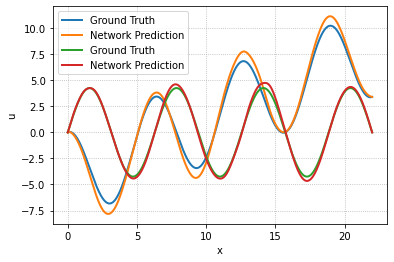

In [7]:
x_test = torch.linspace(0, 7*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
my_network = my_network.cpu()
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")